In [1]:
import os

import pandas as pd

from src.dataPipeline import DataPipeline

os.chdir('..')

In [12]:
from sklearn.impute import SimpleImputer, KNNImputer
import numpy as np

imputer = KNNImputer(n_neighbors=5)
#imputer = SimpleImputer(strategy='mean')

dp = DataPipeline()
df = dp.runPipeline(normalizeAndStandardize=True, imputer=imputer)
df_kaggle = dp.prepare_kaggle_dataset(filePath='./data/test_data-Kaggle-v0.11.csv', normalizeAndStandardize=True,
                                      imputer=imputer)

C:\FHNW_Programmiersachen\5_Sem\immo_challenge\src\dataPipeline.py:46: DtypeWarning: Columns (3,4,5,6,11,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,45,46,47,49,50,107,110,114,115,116,119,120,121,124,125,126,128,131,132) have mixed types. Specify dtype option on import or set low_memory=False.
  self.data = pd.read_csv(filePath)
C:\FHNW_Programmiersachen\5_Sem\immo_challenge\src\dataPipeline.py:73: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  ]].bfill(axis=1)['Space extracted']
C:\FHNW_Programmiersachen\5_Sem\immo_challenge\src\dataPipeline.py:78: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To o

In [13]:
df

,lat,lon,price_cleaned,Space extracted
0,1.516727,0.481087,1150000.0,-0.442389
1,1.521458,0.477934,1420000.0,-0.004914
2,1.489523,0.423897,720000.0,-0.497074
3,1.513855,0.480894,1430000.0,-0.020538
4,1.490555,0.440519,995000.0,-0.114283
...,...,...,...,...
22476,1.006595,1.984304,475000.0,-0.426765
22477,1.616056,1.532445,1490000.0,0.729420
22478,1.611676,1.520457,1450000.0,0.651299
22479,1.732392,1.396360,1290000.0,0.143515


In [2]:
from src.utils.helperFunctions import pickle_dataframe, unpickle_dataframe

df = unpickle_dataframe('df_with_bert_feature.pkl')
df_kaggle = unpickle_dataframe('df_kaggle_with_bert_feature.pkl')

DataFrame loaded from df_with_bert_feature.pkl.
DataFrame loaded from df_kaggle_with_bert_feature.pkl.


In [17]:
# Import necessary libraries
import numpy as np
from sklearn.model_selection import train_test_split
from pygam import LinearGAM, s
from sklearn.metrics import mean_absolute_percentage_error

y = df['price_cleaned']
y_log = np.log(y)
#y_log = y

X = df.drop(columns=['price_cleaned'])



train_test_split_ratio = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=train_test_split_ratio)

X_train_np = X_train.to_numpy()
X_test_np = X_test.to_numpy()

if X_train_np.ndim == 1:
    X_train_np = X_train_np.reshape(-1, 1)
if X_test_np.ndim == 1:
    X_test_np = X_test_np.reshape(-1, 1)


# Initialize Splines
model =  LinearGAM(s(0) + s(1) + s(2)).gridsearch(X_train_np, y_train)

# Train the model
model.fit(X_train_np, y_train)

y_pred = model.predict(X_test_np)

y_test = np.exp(y_test)
y_pred = np.exp(y_pred)

mape = mean_absolute_percentage_error(y_test, y_pred) * 100

print(f'Test MAPE: {mape:.3f}%')

# Train Mape
y_pred = model.predict(X_train_np)
y_train = np.exp(y_train)
y_pred = np.exp(y_pred)

mape = mean_absolute_percentage_error(y_train, y_pred) * 100

print(f'Train MAPE: {mape:.3f}%')

100% (11 of 11) |########################| Elapsed Time: 0:00:03 Time:  0:00:030:00


Test MAPE: 45.865%
Train MAPE: 41.911%


In [18]:
from src.utils.helperFunctions import create_kaggle_results

results = model.predict(df_kaggle)
results = np.exp(results)
create_kaggle_results(results, csv_name='KNN_Regressor_with_bert_feature')

C:\FHNW_Programmiersachen\5_Sem\immo_challenge\src\utils\helperFunctions.py:13: DtypeWarning: Columns (3,4,5,6,11,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,45,46,48,49,104,111,112,115,116,117,120,121,122,124,127,128,130,131) have mixed types. Specify dtype option on import or set low_memory=False.
  indexes = pd.read_csv(path_to_kaggledata)['Unnamed: 0']


File KNN_Regressor_with_bert_feature_2024-12-25_16-58-57.csv created successfully.


In [4]:
from src.utils.helperFunctions import analyse_highest_errors

y_pred = np.exp(model.predict(X_test_np))

error_df_test = analyse_highest_errors(y_test, y_pred, X_test, dp)
error_df_test

NameError: name 'dp' is not defined

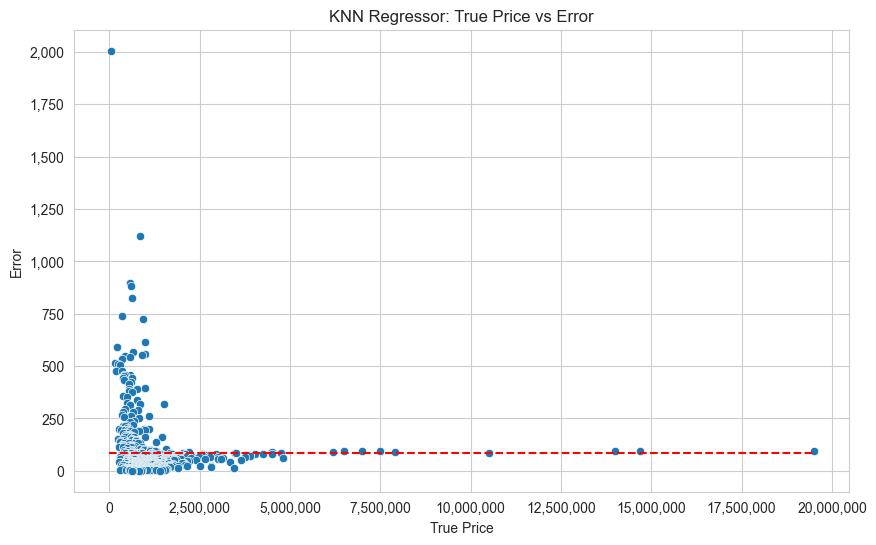

In [27]:
# Plot price vs error
import matplotlib.ticker as ticker
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.scatterplot(x=error_df_test['true_price'], y=error_df_test['mape'])
plt.xlabel('True Price')
plt.ylabel('Error')
plt.gca().xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))  # Format x-axis
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))  # Format y-axis
plt.title('KNN Regressor: True Price vs Error')
plt.hlines(y=error_df_test['mape'].mean(), xmin=0, xmax=error_df_test['true_price'].max(), color='red', linestyles='dashed')
plt.show()

In [28]:
y_pred = np.exp(model.predict(X_train_np))

error_df_train = analyse_highest_errors(y_train, y_pred, X_train, dp)
error_df_train

,detail_responsive#surface_usable,gde_population,gde_tax,Space extracted,Plot_area_unified,No. of rooms:,region_group_0,region_group_1,region_group_2,region_group_3,...,region_group_19,region_group_20,region_group_21,region_group_22,region_group_23,region_group_24,true_price,predicted_price,error,mape
9421,143.60,2435.00,3.60,1458.00,2736.00,9.50,0.00,0.00,0.00,1.00,...,0.00,0.00,0.00,0.00,0.00,0.00,190000.00,12493323.18,12303323.18,6475.43
15196,99.20,8067.00,2.93,1300.00,6500.00,20.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,295000.00,15711696.65,15416696.65,5226.00
1702,122.20,12342.00,8.42,470.00,188.00,9.50,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,100000.00,4271325.48,4171325.48,4171.33
6920,151.20,63932.00,3.60,144.40,271.60,5.00,0.00,0.00,1.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,30000.00,1119620.73,1089620.73,3632.07
7681,192.20,198979.00,3.21,750.00,234.00,21.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,370000.00,13453665.94,13083665.94,3536.13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15641,208.40,21868.00,3.09,180.00,689.60,6.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,NaN,2994790.53,NaN,NaN
15643,128.40,1537.00,6.53,277.00,1644.00,5.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,NaN,1535182.30,NaN,NaN
15644,222.40,1433.00,5.30,138.00,968.00,5.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,NaN,944346.45,NaN,NaN
15647,125.60,8674.00,4.37,40.00,2357.40,1.50,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,NaN,244268.06,NaN,NaN


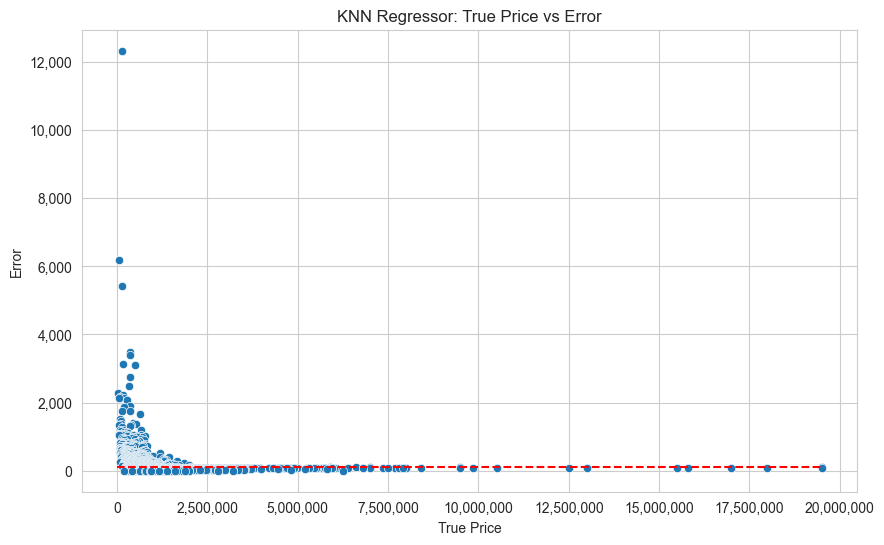

In [14]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=error_df_train['true_price'], y=error_df_train['mape'])
plt.xlabel('True Price')
plt.ylabel('Error')
plt.gca().xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))  # Format x-axis
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))  # Format y-axis
plt.title('KNN Regressor: True Price vs Error')
plt.hlines(y=error_df_train['mape'].mean(), xmin=0, xmax=error_df_train['true_price'].max(), color='red', linestyles='dashed')
plt.show()